# Project 3: Poisonous Mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 examples, where each describes a mushroom by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. The feature space has been binarized. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using k-means and density estimation with Gaussian mixture models (GMM). Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please **prepare your own write-up and write your own code**.

In [1]:
%matplotlib inline

import urllib.request as urllib2 # For python3
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

In [2]:
MUSHROOM_DATA = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.data'
MUSHROOM_MAP = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.map'

Load feature names.

In [3]:
feature_names = []

for line in urllib2.urlopen(MUSHROOM_MAP):
    [index, name, junk] = line.decode('utf-8').split()
    feature_names.append(name)

print('Loaded feature names: ', len(feature_names))
print(feature_names)

Loaded feature names:  126
['cap-shape=bell', 'cap-shape=conical', 'cap-shape=convex', 'cap-shape=flat', 'cap-shape=knobbed', 'cap-shape=sunken', 'cap-surface=fibrous', 'cap-surface=grooves', 'cap-surface=scaly', 'cap-surface=smooth', 'cap-color=brown', 'cap-color=buff', 'cap-color=cinnamon', 'cap-color=gray', 'cap-color=green', 'cap-color=pink', 'cap-color=purple', 'cap-color=red', 'cap-color=white', 'cap-color=yellow', 'bruises?=bruises', 'bruises?=no', 'odor=almond', 'odor=anise', 'odor=creosote', 'odor=fishy', 'odor=foul', 'odor=musty', 'odor=none', 'odor=pungent', 'odor=spicy', 'gill-attachment=attached', 'gill-attachment=descending', 'gill-attachment=free', 'gill-attachment=notched', 'gill-spacing=close', 'gill-spacing=crowded', 'gill-spacing=distant', 'gill-size=broad', 'gill-size=narrow', 'gill-color=black', 'gill-color=brown', 'gill-color=buff', 'gill-color=chocolate', 'gill-color=gray', 'gill-color=green', 'gill-color=orange', 'gill-color=pink', 'gill-color=purple', 'gill-col

Load data. The dataset is sparse, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [4]:
X, Y = [], []

for line in urllib2.urlopen(MUSHROOM_DATA):
    items = line.decode('utf-8').split()
    Y.append(int(items.pop(0)))
    x = np.zeros(len(feature_names))
    for item in items:
        feature = int(str(item).split(':')[0])
        x[feature] = 1
    X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


### Part 1:

Do a principal components analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].  Also show a lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.

Notes:
* You can use `PCA` to produce a PCA analysis.

k     fraction explained
1      0.164
2      0.297
3      0.399
4      0.470
5      0.508
10     0.652
20     0.809
30     0.898
40     0.951
50     0.982


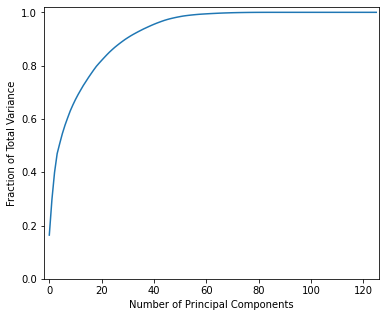

In [5]:
def P1():
    all_k = list(range(1, train_data.shape[1] + 1, 1))
    explained_var = list()
    select_k = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]
    print("k".ljust(5), "fraction explained")
    for k in all_k:
        model = PCA(n_components=k).fit(train_data)
        fraction_explained = model.explained_variance_ratio_.sum()
        explained_var.append(fraction_explained)
        if k in select_k:
            print(f"{k}".ljust(6), f"{fraction_explained:.3f}")
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.plot(range(max(all_k)), explained_var)
    ax.set_xlabel("Number of Principal Components")
    ax.set_ylabel("Fraction of Total Variance")
    ax.set_ylim(0, 1.02)
    ax.set_xlim(-2, max(all_k))
    plt.show()

    
P1()

### Part 2:

PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and show as a square scatterplot. Show the positive (poisonous) examples in red and the negative (non-poisonous) examples in green. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

Notes:
* You can use `PCA` to produce a PCA analysis.

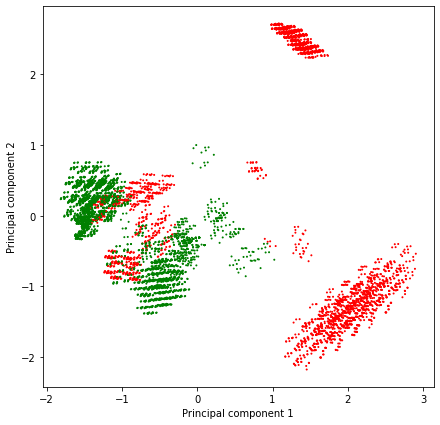

In [6]:
def P2():
    pca_model = PCA(n_components=2)
    transformed = pca_model.fit_transform(train_data)
    colors = {0: "g", 1: "r"}
    color_list = [colors[i] for i in train_labels]
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.scatter(transformed[:, 0], transformed[:, 1], c=color_list, s=1)
    ax.set_xlabel("Principal component 1")
    ax.set_ylabel("Principal component 2")
    plt.show()


P2()

### Part 3:

Fit a k-means cluster model with 6 clusters over the 2d projected data. As in part 2, show as a square scatterplot with the positive (poisonous) examples in red and the negative (non-poisonous) examples in green.  For each cluster, mark the centroid and plot a circle that goes through the cluster's example that is most distant from the centroid.

Notes:
* You can use `KMeans` to produce a k-means cluster analysis.
* You can use `linalg.norm` to determine distance (dissimilarity) between observations.

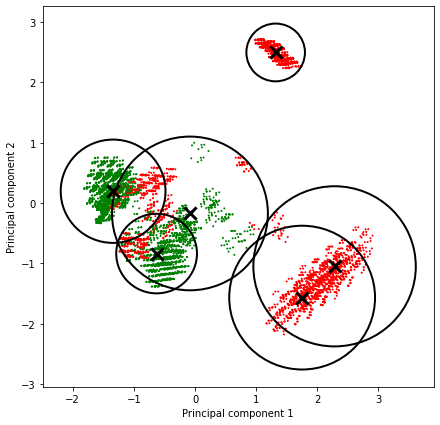

In [7]:
def P3():
    # Fit the PCA model and plot as before:
    pca_model = PCA(n_components=2)
    transformed = pca_model.fit_transform(train_data)
    colors = {0: "g", 1: "r"}
    color_list = [colors[i] for i in train_labels]
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.scatter(transformed[:, 0], transformed[:, 1], c=color_list, s=1)
    ax.set_xlabel("Principal component 1")
    ax.set_ylabel("Principal component 2")

    # Fit the KMeans model:
    km_model = KMeans(n_clusters=6).fit(transformed)

    # Plot the centroids and circles:
    for i, centroid in enumerate(km_model.cluster_centers_):
        ax.scatter(centroid[0], centroid[1], c="black", marker="x", s=150, linewidths=3)
        indices = np.where(km_model.labels_ == i)[0]
        distance = max([np.linalg.norm(p - centroid) for p in transformed[indices]])
        circle = plt.Circle(centroid, distance, color="black", fill=False, lw=2)
        ax.add_patch(circle)

    plt.show()
    
    
P3()

### Part 4:

Fit Gaussian mixture models for the positive (poisonous) examples in your 2d projected data. Vary the number of mixture components from 1 to 4 and the covariance matrix type 'spherical', 'diag', 'tied', 'full' (that's 16 models).  Show square plots of the estimated density contours presented in a 4x4 grid - one row each for a number of mixture components and one column each for a convariance matrix type.  

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* You can use `contour` in combination with other methods to plot contours, like in this example: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py
* You can use `contour` without the `norm` and `levels` parameters. 

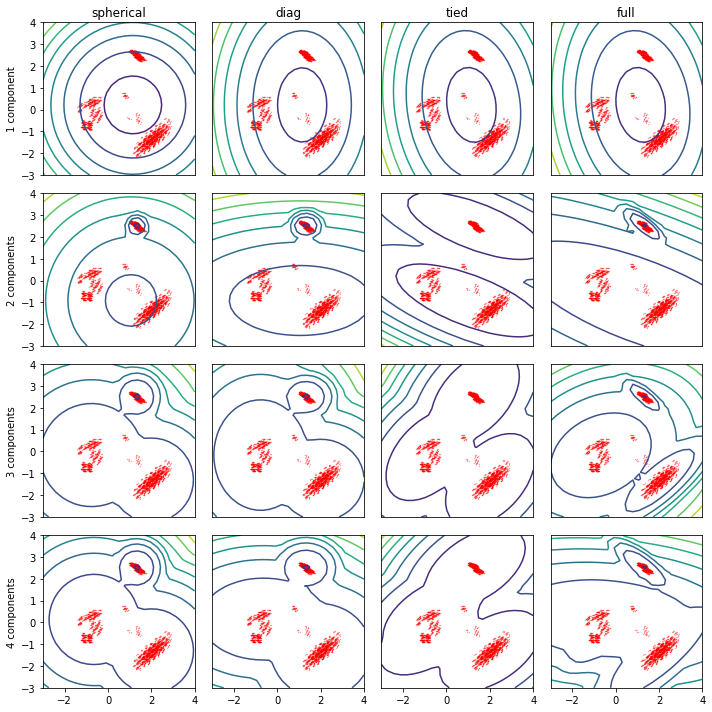

In [8]:
def P4():

    # Create 2d projection:
    pca_model = PCA(n_components=2)
    transformed = pca_model.fit_transform(train_data)

    # Select poisonous (label == 1):
    poisonous = transformed[np.where(train_labels == 1)]

    # Parameters for the meshgrid:
    x = np.linspace(-3., 4., 25)
    y = np.linspace(-3., 4., 25)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T

    # Produce the plots:
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for row, c in enumerate((1, 2, 3, 4)):
        for col, cov in enumerate(("spherical", "diag", "tied", "full")):
            gmm_model = GaussianMixture(n_components=c, covariance_type=cov, random_state=42)
            gmm_model.fit(poisonous)
            Z = -gmm_model.score_samples(XX)
            Z = Z.reshape(X.shape)
            ax = axes[row, col]
            ax.scatter(poisonous[:, 0], poisonous[:, 1], s=0.1, c="r", alpha=0.5)
            ax.contour(X, Y, Z)
            if row == 0:
                ax.set_title(cov)
            if col == 0:
                ax.set_ylabel(f"{c} component{'s' if c>1 else ''}")
            if row != 3:
                ax.set_xticks([])
            if col != 0:
                ax.set_yticks([])
    fig.tight_layout() 


P4()

### Part 5:

Fit two Gaussian mixture models, one for the positive examples and one for the negative examples in your 2d projected data. Use 4 mixture components and full convariance for each model.  Predict the test example labels by picking the labels corresponding to the larger of the two models' probabilities.  What is the accuracy of you predictions on the test data?

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* You can use `GaussianMixture`'s `score_samples` method to find the probabilities.

In [9]:
def P5():

    # Create 2d projection:
    pca_model = PCA(n_components=2)
    transformed = pca_model.fit_transform(train_data)

    # Select subsets of training data based on label:
    positive = transformed[np.where(train_labels == 1)]
    negative = transformed[np.where(train_labels == 0)]

    # Fit the models:
    pos_model = GaussianMixture(n_components=4, covariance_type="full", random_state=42).fit(positive)
    neg_model = GaussianMixture(n_components=4, covariance_type="full", random_state=42).fit(negative)

    # Transform test data with the PCA model:
    transformed_test = pca_model.transform(test_data)

    # Get the probabilities & prediction, and score accuracy:
    probs_pos = pos_model.score_samples(transformed_test)
    probs_neg = neg_model.score_samples(transformed_test)
    pred = np.argmax(np.vstack([probs_neg, probs_pos]).T, axis=1)
    n_correct = np.where(pred == test_labels, 1, 0).sum()
    n = len(test_labels)
    accuracy = n_correct / n
    print(f"{n_correct:} correct predictions out of {n:}, accuracy = {accuracy:.3f}")
    

P5()

1060 correct predictions out of 1124, accuracy = 0.943


### Part 6:

Run a series of experiments to find the Gaussian mixture model that results in the best accuracy with no more than 50 parameters.  Do this by varying the number of PCA components, the number of GMM components, and the covariance type.

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.


* For spherical, diag, and full covariance types:
  * number of parameters = (number of parameters per gmm component * number of gmm components - 1) * number of classes
  * number of parameters per gmm component includes all the means plus all the non-zero, non-duplicated values in the covariance matrix plus the mixing weight
  * Each mixing weight parameter indicates how much to weight a particular gmm component; the -1 above accounts for the fact that the mixing weights must sum to 1, so you do not need to include the last mixing weight as its own parameter


* To calculate the number of parameters for tied covariance type:
  * number of parameters = (number of parameters per class - 1) * number of classes
  * number of parameters per class includes all the means and mixing weights for all the gmm components plus all the non-zero, non-duplicated values in the one shared covariance matrix
  * Each mixing weight parameter indicates how much to weight a particular gmm component; the -1 above accounts for the fact that the mixing weights must sum to 1, so you do not need to include the last mixing weight as its own parameter

In [10]:
from itertools import product  # For permuting parameters.


def P6():
    
    def param_count(cov_type: str, n_pca: int, n_gmm: int, n_classes: int):
        """Calculate the number of parameters a model has."""
        n_mean = n_pca * n_gmm  # Same for all cov_type.
        n_weights = n_gmm - 1  # Same for all cov_type.
        upper_triangle = int(n_pca * (n_pca + 1) / 2)  # Covariance matrix upper triangle.
        return {
            "full": (n_weights + n_mean + (upper_triangle * n_gmm)) * n_classes,
            "diag": (n_weights + (2 * n_mean)) * n_classes,
            "spherical": (n_weights + n_mean + n_gmm) * n_classes,
            "tied": (n_weights + n_mean + upper_triangle) * n_classes,
        }[cov_type]
    
    # Create all possible parameter combinations with <=50 total parameters:
    cov_types = ["spherical", "diag", "tied", "full"]
    pca_components = range(1, 51, 1)
    gmm_components = range(1, 51, 1)
    perms = list(product(cov_types, pca_components, gmm_components))
    counts = [param_count(cov, pca, gmm, 2) for cov, pca, gmm in perms]
    params_count = [(p, int(c)) for p, c in zip(perms, counts) if c <= 50]

    # Create models for each parameter combination, score accuracy on test set:
    best_cov, best_pca, best_gmm, best_accuracy, best_n_params = None, None, None, -np.inf, None
    print(f"Results for all parameter combinations:\n")
    print("cov_type".ljust(10), "n_pca".ljust(8), "n_gmm".ljust(8), "n_params".ljust(10), "accuracy")
    for (cov, pca, gmm), count in params_count:

        # Create PCA projection:
        pca_model = PCA(n_components=pca)
        transformed = pca_model.fit_transform(train_data)

        # Select subsets:
        positive = transformed[np.where(train_labels == 1)]
        negative = transformed[np.where(train_labels == 0)]

        # Fit GMM models:
        pos_model = GaussianMixture(n_components=gmm, covariance_type=cov, random_state=42).fit(positive)
        neg_model = GaussianMixture(n_components=gmm, covariance_type=cov, random_state=42).fit(negative)

        # Transform test data:
        transformed_test = pca_model.transform(test_data)

        # Get the probabilities & prediction, and score accuracy:
        probs_pos = pos_model.score_samples(transformed_test)
        probs_neg = neg_model.score_samples(transformed_test)
        pred = np.argmax(np.vstack([probs_neg, probs_pos]).T, axis=1)
        accuracy = metrics.accuracy_score(test_labels, pred)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_cov, best_pca, best_gmm = cov, pca, gmm
            best_n_params = count

        print(f"{cov}".ljust(10), f" {pca}".ljust(8), f" {gmm}".ljust(8),
              f" {count}".ljust(10), f"{accuracy:.3f}")

    print(f"\nBest parameters:\n")
    print("cov_type".ljust(10), "n_pca".ljust(8), "n_gmm".ljust(8), "n_params".ljust(10), "accuracy")
    print(f"{best_cov}".ljust(10), f" {best_pca}".ljust(8), f" {best_gmm}".ljust(8), 
          f" {best_n_params}".ljust(10), f"{best_accuracy:.3f}")


P6()

Results for all parameter combinations:

cov_type   n_pca    n_gmm    n_params   accuracy
spherical   1        1        4         0.844
spherical   1        2        10        0.899
spherical   1        3        16        0.907
spherical   1        4        22        0.914
spherical   1        5        28        0.914
spherical   1        6        34        0.912
spherical   1        7        40        0.910
spherical   1        8        46        0.906
spherical   2        1        6         0.860
spherical   2        2        14        0.876
spherical   2        3        22        0.946
spherical   2        4        30        0.943
spherical   2        5        38        0.940
spherical   2        6        46        0.948
spherical   3        1        8         0.872
spherical   3        2        18        0.868
spherical   3        3        28        0.907
spherical   3        4        38        0.956
spherical   3        5        48        0.962
spherical   4        1        10    